# Lab. 3: Momentum I

In this lab we will explore the signal research proccess with the classic Jegadeesh and Titman momentum signal.

We will explore:
- How to compute signals with point in time compliance in mind.
- The need to filter out low priced securities.
- How to create decile and spread portfolios.
- Strategy performance metrics.

## Imports

In [2]:
import sf_quant.data as sfd
import polars as pl
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data

We will be looking at our investment universe from 1996 to 2024.

This should take around 10 seconds to run.

In [3]:
start = dt.date(1996, 1, 1)
end = dt.date(2024, 12, 31)

columns = [
    'date',
    'barrid',
    'ticker',
    'price',
    'return',
    'market_cap'
]

data = sfd.load_assets(
    start=start,
    end=end,
    in_universe=True,
    columns=columns
)

data

date,barrid,ticker,price,return,market_cap
date,str,str,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.1595,6.006157e8
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.9585,6.0865392e8
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.1582,6.0769086e8
2013-08-05,"""USA06Z1""","""MDXG""",6.45,2.2187,6.211737e8
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-2.4806,6.0576474e8
…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,2.5872,3.5976e9
2024-12-26,"""USBQOR1""","""ECG""",73.61,4.293,3.7521e9
2024-12-27,"""USBQOR1""","""ECG""",69.85,-5.108,3.5604e9


## Compute the Momentum Signal

## Instructions

- Compute momentum for each security and date as the rolling 230 day return (you can just use log returns here).
- Shift the momentum signal 22 days. This will results in the 11 month return from t-12 to t-2.

In [4]:
def task_compute_momentum(data: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the t_12 to t_2 momentum signal for each secrutiy and date combination.
    
    Args:
        data (pl.DataFrame): Data frame containing date, barrid, price, and return columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """
    return (
        data
        .with_columns(
            pl.col('return').truediv(100)
        )
        .with_columns(
            log_return = pl.col('return').log1p()
        )
        .sort('barrid', 'date')
        .with_columns(
            momentum = pl.col('log_return').rolling_sum(window_size=230).over('barrid')
        )
        .with_columns(
            pl.col('momentum').shift(22).over('barrid')
        )
    )

momentum = task_compute_momentum(data)

momentum

date,barrid,ticker,price,return,market_cap,log_return,momentum
date,str,str,f64,f64,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.001595,6.006157e8,-0.001596,null
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.009585,6.0865392e8,0.009539,null
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.001582,6.0769086e8,-0.001583,null
2013-08-05,"""USA06Z1""","""MDXG""",6.45,0.022187,6.211737e8,0.021944,null
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-0.024806,6.0576474e8,-0.025119,null
…,…,…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,0.025872,3.5976e9,0.025543,null
2024-12-26,"""USBQOR1""","""ECG""",73.61,0.04293,3.7521e9,0.042034,null
2024-12-27,"""USBQOR1""","""ECG""",69.85,-0.05108,3.5604e9,-0.052431,null


In [5]:
first_values = (
    momentum
    .filter(pl.col('momentum').is_not_null())
    .group_by('barrid')
    .head(1)
)

print(first_values)

shape: (9_383, 8)
┌─────────┬────────────┬────────┬────────┬───────────┬─────────────┬────────────┬───────────┐
│ barrid  ┆ date       ┆ ticker ┆ price  ┆ return    ┆ market_cap  ┆ log_return ┆ momentum  │
│ ---     ┆ ---        ┆ ---    ┆ ---    ┆ ---       ┆ ---         ┆ ---        ┆ ---       │
│ str     ┆ date       ┆ str    ┆ f64    ┆ f64       ┆ f64         ┆ f64        ┆ f64       │
╞═════════╪════════════╪════════╪════════╪═══════════╪═════════════╪════════════╪═══════════╡
│ USA06Z1 ┆ 2014-07-30 ┆ MDXG   ┆ 7.1    ┆ 0.009957  ┆ 7.410696e8  ┆ 0.009908   ┆ 0.101525  │
│ USA0771 ┆ 2015-06-29 ┆ UIHC   ┆ 15.82  ┆ -0.004405 ┆ 3.3971e8    ┆ -0.004415  ┆ -0.126918 │
│ USA0BJ1 ┆ 2013-07-02 ┆ BLMT   ┆ 13.22  ┆ -0.011958 ┆ 1.2126706e8 ┆ -0.01203   ┆ 0.086478  │
│ USA0C01 ┆ 2017-06-29 ┆ WFBI   ┆ 34.54  ┆ 0.009646  ┆ 4.2155e8    ┆ 0.0096     ┆ 0.506896  │
│ USA0C11 ┆ 2012-10-31 ┆ FBHS   ┆ 28.44  ┆ 0.026344  ┆ 4.5398e9    ┆ 0.026003   ┆ 0.611123  │
│ …       ┆ …          ┆ …      ┆ …      ┆

## Price and Momentum Filter

When doing backtesting strategies it's helpful to drop securities with a price below $5.

- Create a variable price_lag that is the previous days price for each security.
- Filter securities to ones with a lagged price greater than 5.
- Drop null momentum values since we won't trade securities where we don't have a signal.

In [6]:
def task_price_filter(momentum: pl.DataFrame) -> pl.DataFrame:
    """
    Filter the universe to lagged price greater than 5 and non-null momentum.
    
    Args:
        momentum (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """
    return (
        momentum
        .sort('barrid', 'date')
        .with_columns(
            price_lag = pl.col('price').shift(1).over('barrid')
        )
        .filter(
            pl.col('price_lag').gt(5),
            pl.col('momentum').is_not_null()
        )
        .sort('barrid', 'date')
    )

price_filter = task_price_filter(momentum)

price_filter

date,barrid,ticker,price,return,market_cap,log_return,momentum,price_lag
date,str,str,f64,f64,f64,f64,f64,f64
2014-07-30,"""USA06Z1""","""MDXG""",7.1,0.009957,7.410696e8,0.009908,0.101525,7.03
2014-07-31,"""USA06Z1""","""MDXG""",6.91,-0.026761,7.2123816e8,-0.027126,0.124505,7.1
2014-08-01,"""USA06Z1""","""MDXG""",6.81,-0.014472,7.1080056e8,-0.014578,0.167176,6.91
2014-08-04,"""USA06Z1""","""MDXG""",7.08,0.039648,7.3898208e8,0.038882,0.159344,6.81
2014-08-05,"""USA06Z1""","""MDXG""",7.05,-0.004237,7.358508e8,-0.004246,0.14279,7.08
…,…,…,…,…,…,…,…,…
2024-12-27,"""USBPJV1""","""NLOP""",30.81,-0.019414,4.5553e8,-0.019605,0.527437,31.42
2024-12-30,"""USBPJV1""","""NLOP""",31.08,0.008763,4.5952e8,0.008725,0.522813,30.81
2024-12-31,"""USBPJV1""","""NLOP""",31.21,0.004183,4.6144e8,0.004174,0.552793,31.08


## Create Decile Portfolios

### Instructions

- For each date divide all securities into 10 deciles based on their momentum score. The highest momentum securities should be in bin 9 and the lowest momentum securities should be in bin 0. The `.qcut()` expression will be helpful here.


In [7]:
def task_momentum_bins(price_filter: pl.DataFrame) -> pl.DataFrame:
    """
    Bin the securities into deciles for each date by momentum.
    
    Args:
        price_filter (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, momentum and bin columns.
    """
    n_bins = 10
    labels = [str(i) for i in range(n_bins)]
    
    return (
        price_filter
        .with_columns(
            bin = pl.col('momentum').qcut(n_bins, labels=labels).over('date')
        )
    )

momentum_bins = task_momentum_bins(price_filter)

momentum_bins

date,barrid,ticker,price,return,market_cap,log_return,momentum,price_lag,bin
date,str,str,f64,f64,f64,f64,f64,f64,cat
2014-07-30,"""USA06Z1""","""MDXG""",7.1,0.009957,7.410696e8,0.009908,0.101525,7.03,"""4"""
2014-07-31,"""USA06Z1""","""MDXG""",6.91,-0.026761,7.2123816e8,-0.027126,0.124505,7.1,"""4"""
2014-08-01,"""USA06Z1""","""MDXG""",6.81,-0.014472,7.1080056e8,-0.014578,0.167176,6.91,"""5"""
2014-08-04,"""USA06Z1""","""MDXG""",7.08,0.039648,7.3898208e8,0.038882,0.159344,6.81,"""5"""
2014-08-05,"""USA06Z1""","""MDXG""",7.05,-0.004237,7.358508e8,-0.004246,0.14279,7.08,"""5"""
…,…,…,…,…,…,…,…,…,…
2024-12-27,"""USBPJV1""","""NLOP""",30.81,-0.019414,4.5553e8,-0.019605,0.527437,31.42,"""8"""
2024-12-30,"""USBPJV1""","""NLOP""",31.08,0.008763,4.5952e8,0.008725,0.522813,30.81,"""8"""
2024-12-31,"""USBPJV1""","""NLOP""",31.21,0.004183,4.6144e8,0.004174,0.552793,31.08,"""9"""


## Equal Weight Portfolios

For each date and bin combo compute the equal weight return.

### Instructions
- Use `.group_by()` to find the average return for each decile on each date.
- Pivot the data frame into index=date, columns=bins, and values=returns (`.pivot()`)
- Compute the spread portfolio as the return of bin 9 minus the return of bin 0

In [8]:
def task_equal_weight_portfolios(momentum_bins: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_bins (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date as the index, bins as the columns, and returns as the values.
    """
    return (
        momentum_bins
        .group_by('date', 'bin')
        .agg(
            pl.col('return').mean()
        )
        .sort('date')
        .pivot(index='date', on='bin', values='return')
        .sort('date')
        .with_columns(
            spread = pl.col('9').sub('0')
        )
    )

momentum_portfolios = task_equal_weight_portfolios(momentum_bins)

momentum_portfolios

date,2,1,0,8,7,4,3,9,5,6,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1996-12-27,0.003391,0.002869,-0.00093,0.003746,0.00353,0.003963,0.004531,-0.000883,0.005852,0.002967,0.000047
1996-12-30,-0.001631,-0.002172,-0.008736,0.004764,0.002099,0.003705,0.000936,0.000325,0.003443,0.002544,0.009061
1996-12-31,0.000181,0.003781,0.011733,-0.001622,-0.001242,0.001242,0.000061,0.004894,0.001585,0.003932,-0.006839
1997-01-02,-0.00481,-0.001642,0.007561,-0.013547,-0.011045,-0.006687,-0.007111,-0.01781,-0.007558,-0.00929,-0.025371
1997-01-03,0.008087,0.013244,0.018497,0.010573,0.009103,0.006034,0.007845,0.012844,0.006642,0.006741,-0.005653
…,…,…,…,…,…,…,…,…,…,…,…
2024-12-24,0.008055,0.007633,0.007357,0.011663,0.009136,0.007919,0.007497,0.013276,0.007974,0.008316,0.005919
2024-12-26,0.006301,0.008819,0.017455,0.007306,0.005329,0.003854,0.006043,0.010651,0.004201,0.003957,-0.006805
2024-12-27,-0.010328,-0.012441,-0.014529,-0.014801,-0.013104,-0.010892,-0.011024,-0.020485,-0.012319,-0.011748,-0.005956


## Portfolio Returns

Compute the cumulative returns of each bin.

### Instructions
- Use the `.unpivot()` method to put our data frame back into long format.
- Compute the cumulative log return.
- Put the return columns into percent space by multiplying by 100.

In [9]:
def task_cumulative_returns(momentum_portfolios: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_portfolios (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date, bin, return, and cumulative_log_return columns.
    """
    
    return (
        momentum_portfolios
        .unpivot(index='date', variable_name='bin', value_name='return')
        .with_columns(
            cumulative_log_return = pl.col('return').log1p().cum_sum().over('bin')
        )
        .with_columns(
            pl.col('return', 'cumulative_log_return').mul(100)
        )
    )

momentum_returns = task_cumulative_returns(momentum_portfolios)

momentum_returns

date,bin,return,cumulative_log_return
date,str,f64,f64
1996-12-27,"""2""",0.339095,0.338522
1996-12-30,"""2""",-0.163141,0.175247
1996-12-31,"""2""",0.018091,0.193337
1997-01-02,"""2""",-0.481008,-0.288832
1997-01-03,"""2""",0.808748,0.516663
…,…,…,…
2024-12-24,"""spread""",0.591908,231.966704
2024-12-26,"""spread""",-0.68046,231.283919
2024-12-27,"""spread""",-0.595633,230.686504


## Performance Analysis

### Instructions
- Chart the cumulative log returns of the 10 decile portfolios and the spread portfolio.
- Create a table with average daily return (annualized), volatility (annualized), and sharpe ratio (annualized) for each portfolio.

In [10]:
n_bins = 10
labels = [str(i) for i in range(n_bins)]

momentum_returns_analysis = (
    momentum_returns
    .sort('bin')
    .pivot(index='date', on='bin', values='cumulative_log_return')
)

momentum_returns_analysis

date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1996-12-27,-0.093,0.286536,0.338522,0.452034,0.395548,0.583538,0.296309,0.352366,0.373918,-0.088303,0.004692
1996-12-30,-0.970398,0.069063,0.175247,0.545558,0.765399,0.927232,0.550364,0.562051,0.849167,-0.055764,0.906717
1996-12-31,0.196093,0.446404,0.193337,0.551632,0.889569,1.085595,0.94275,0.437787,0.686848,0.432432,0.220436
1997-01-02,0.949329,0.282092,-0.288832,-0.162046,0.218672,0.326939,0.009399,-0.672883,-0.677079,-1.364608,-2.349373
1997-01-03,2.782123,1.597777,0.516663,0.619414,0.820294,0.988947,0.681189,0.233346,0.374687,-0.088385,-2.916268
…,…,…,…,…,…,…,…,…,…,…,…
2024-12-24,44.339391,194.370188,216.444426,287.485703,269.780748,303.918063,295.668557,333.548638,353.993015,396.846089,231.966704
2024-12-26,46.06985,195.248183,217.072584,288.088177,270.165382,304.337256,296.063518,334.080101,354.720964,397.905515,231.283919
2024-12-27,44.60629,193.996284,216.034418,286.979652,269.070158,303.097719,294.881777,332.761001,353.229844,395.835706,230.686504


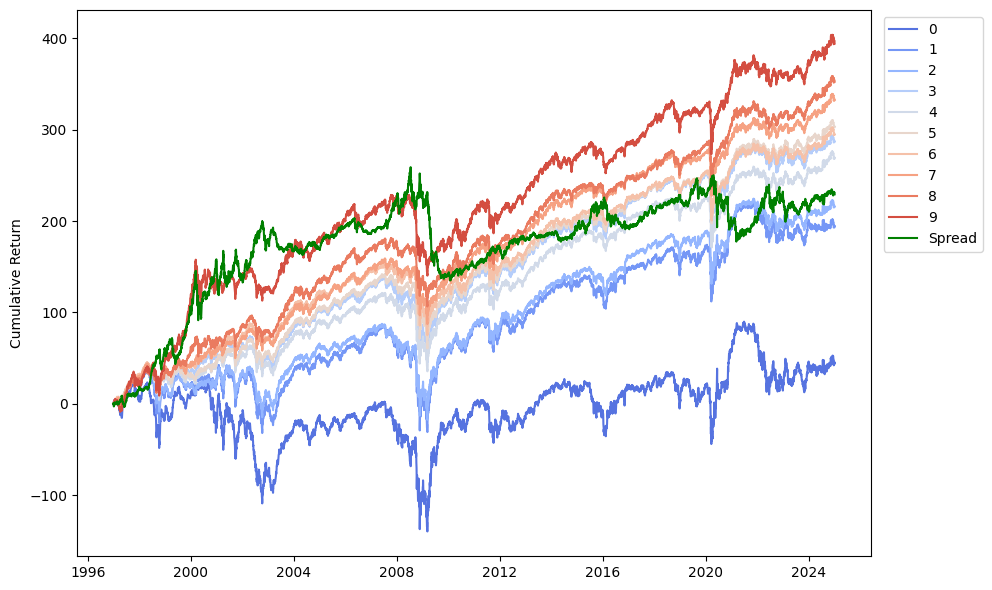

In [11]:
n_bins = 10
labels = [str(i) for i in range(n_bins)]

momentum_returns_analysis = (
    momentum_returns
    .sort('bin')
    .pivot(index='date', on='bin', values='cumulative_log_return')
)

plt.figure(figsize=(10, 6))
colors = sns.color_palette('coolwarm', 10)

for label, color in zip(labels, colors):
    sns.lineplot(momentum_returns_analysis, x='date', y=label, color=color, label=label)

sns.lineplot(momentum_returns_analysis, x='date', y='spread', color='Green', label='Spread')

plt.xlabel("")
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right')

plt.tight_layout()
plt.show()


In [12]:
pl.Config.set_tbl_rows(11)

(
    momentum_returns
    .group_by('bin')
    .agg(
        average_return = pl.col('return').mean().mul(252),
        volatility = pl.col('return').std().mul(pl.lit(252).sqrt())
    )
    .with_columns(
        sharpe_ratio = pl.col('average_return').truediv('volatility')
    )
)

bin,average_return,volatility,sharpe_ratio
str,f64,f64,f64
"""spread""",10.766415,22.525173,0.477973
"""5""",12.884366,20.258775,0.635989
"""9""",17.579534,26.309682,0.668177
"""3""",12.711458,22.111384,0.574883
"""4""",11.810385,20.929741,0.564287
"""7""",13.912943,20.128114,0.691219
"""2""",10.485851,23.551136,0.445238
"""8""",14.882935,21.30075,0.698705
"""0""",6.813119,32.342332,0.210656
